<a href="https://colab.research.google.com/github/uncbiag/OAI_analysis_2/blob/main/notebooks/DaskComputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
# Remember to Restart runtime after installation

!pip install itk==5.3
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!git clone https://github.com/uncbiag/OAI_analysis_2.git
!python -m pip install "dask[complete]"
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git

In [12]:
# All Imports

import numpy as np
import torch
import itk
import vtk
import itkwidgets
import icon_registration
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models

import os
import sys
sys.path.append("./OAI_analysis_2/")

import oai_analysis
from oai_analysis import mesh_processing as mp
from oai_analysis import utils
from oai_analysis.analysis_object import AnalysisObject
from dask import delayed, compute, visualize
from dask.distributed import Client, progress, LocalCluster

In [2]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

Local metadata does not exists. Falling back to download.
[####################################]  74.74M/74.74M  100%  atlas_image.nii.gz          
[####################################]  76.70M/76.70M  100%  FC_probmap.nii.gz          
[####################################]  27.96M/27.96M  100%  image_preprocessed.nii.gz          
[####################################]  76.66M/76.66M  100%  TC_probmap.nii.gz          


In [13]:
# All Function Definitions with Dask Delayed Decorator to perform parallel Computing

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

@delayed
def deform_probmap(phi_AB, image_A, image_B, prob_map):
    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image = itk.resample_image_filter(prob_map, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image
    
@delayed
def get_thickness_FC(warped_image_FC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_FC = mp.get_itk_mesh(distance_inner_FC)
    return distance_inner_FC

@delayed
def get_thickness_TC(warped_image_TC):
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    distance_inner_TC = mp.get_itk_mesh(distance_inner_TC)
    return distance_inner_TC

@delayed(nout=2)
def segment_image(image_A):
    # Segment the input image
    test_volume = itk.imread(image_A, itk.F)
    obj = AnalysisObject()
    FC_probmap, TC_probmap = obj.segment(test_volume)

    return FC_probmap, TC_probmap

@delayed(nout=3)
def only_register_images(image_A, image_B):
    image_A = itk.imread(image_A, itk.D)
    image_B = itk.imread(image_B, itk.D)

    model = pretrained_models.OAI_knees_gradICON_model()
    model.cuda()

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return phi_AB, image_A, image_B

In [14]:
# Create Dask Computation Graph

result = []

image_preprocessed_path = "./OAIData/image_preprocessed.nii.gz"
atlas_image_path = "./OAIData/atlas_image.nii.gz"

phi_AB, image_A, image_B            = only_register_images(image_preprocessed_path, atlas_image_path)
fc_probmap, tc_probmap = segment_image(image_preprocessed_path)

warped_image_FC = deform_probmap(phi_AB, image_A, image_B, fc_probmap)
warped_image_TC = deform_probmap(phi_AB, image_A, image_B, tc_probmap)

thickness_FC = get_thickness_FC(warped_image_FC)
thickness_TC = get_thickness_TC(warped_image_TC)

result.append(thickness_FC)
result.append(thickness_TC)

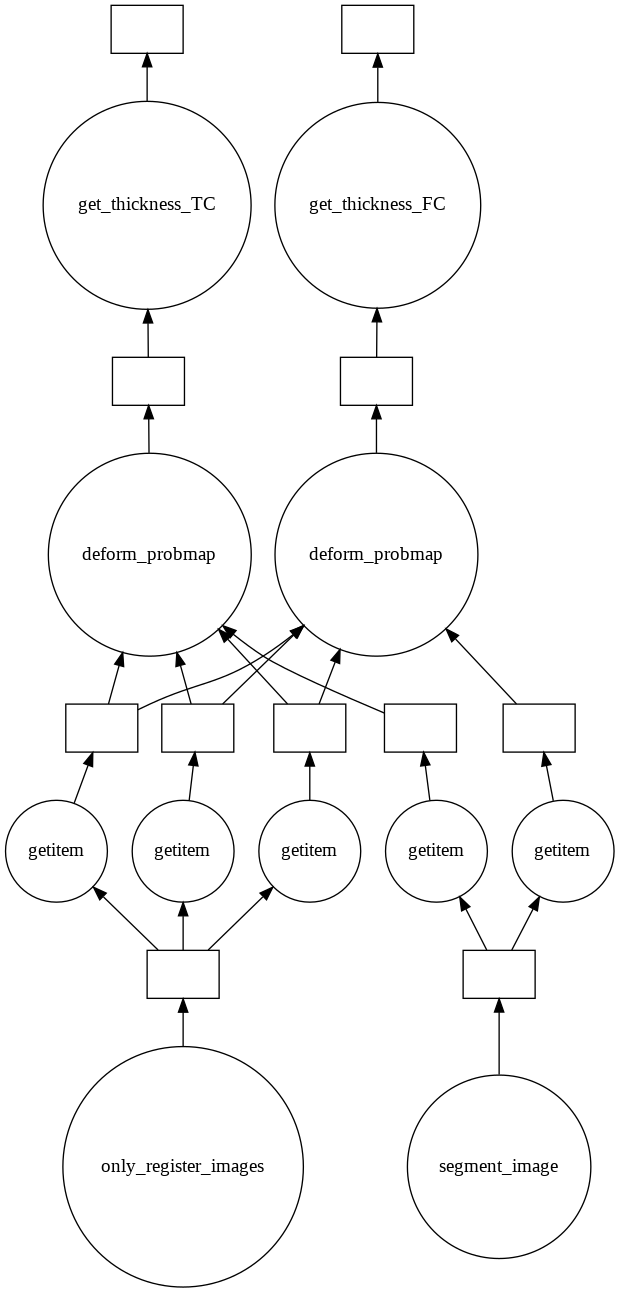

In [15]:
# Visualize Dask Computation Graph

visualize(*result)

In [17]:
# Perform computation
%%time

l = compute(*result)

Loading parameter file = OAI_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint 'OAI_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint 'OAI_analysis_2/data/segmentation_model.pth.tar' (epoch 600)


marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


CPU times: user 1min 52s, sys: 16.5 s, total: 2min 9s
Wall time: 2min 28s


![DaskProgress](https://user-images.githubusercontent.com/1044135/163692457-40a41395-3d83-4928-9445-528cd025a7b9.png)


In [18]:
# Write the result meshes

distance_inner_FC = l[0]
distance_inner_TC = l[1]

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [19]:
# Visualize the meshes with thickness as cell data

# To enable running the itkwidgets window on colab
from google.colab import output
output.enable_custom_widget_manager()

a1 = vtk.vtkPolyDataReader()
a1.SetFileName('itk_distance_inner_FC.vtk')
a1.Update()
distance_inner_FC = a1.GetOutput()

itkwidgets.view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…